# Decentralized Path Planning - Mini Problem Set

### Due Wednesday, April 29, 11:59 p.m.

In this problem set, you'll implement **DMA-RRT** and use it to solve decentralized multiagent path planning problems. Specifically, you will apply it to the VIPER path planning scenario.

1. [Motivation](#motivation)
2. [Modeling](#modeling)
  1. [Modeling Example](#modeling-example)
  2. [Conceptual Question 1 - RRT (5 pts)](#concept1)
  3. [Conceptual Question 2 - Coordination (5 pts)](#concept2)
  4. [Conceptual Question 3 - Negative Bids (5 pts)](#concept3) 
3. [Implement DMA-RRT (35 x 2 = 70 pts)](#DMA-RRT)
4. [Conceptual Question 4 - Cooperative DMA-RRT (5 pts)](#concept4) 
5. [Performance Analysis](#analysis)
  1. [Conceptual Question 5 - The Impact of $\Delta t$ (5 pts)](#concept5) 
  2. [Conceptual Question 6 - Limitations of DMA-RRT(5 pts)](#concept6) 

Make sure you load the following dependencies by highlighting the cell below and pressing `Shift + Enter`.

In [ ]:
from plan import Plan, example_dma_indiv
from agent import Agent, test_received_bid, test_received_waypoints
from environment import Environment

from assignment.utils.test_agent import *
from assignment.utils.test_plan import *

import random

## Motivation <a id="motivation"/>

In brief, NASA's current architecture for lunar exploration is a gradual ramp up of capabilities. The first foray, the Volatiles Investigating Polar Exploration Rover (VIPER), will launch in the 2022 timeframe with the express mission of mapping water-ice at potential Artemis landing sites. From this perspective, we can extrapolate to a concept of operations for planetary exploration wherein teams of rovers are responsible for advanced scouting. If humans are dependent on their results, time will be of the essence.

Furthermore, novel environments will introduce communication challenges. There may not be resources to run central authorities. Ground communications may be limited, spotty, or massively delayed. Given all of these constraints, we need to consider algorithms that allow teams of agents to distribute decision making online. For this problem set, you will address the problem of distributed path planning, focusing on the DMA-RRT algorithm.

Please see the attached tutorial PDF for pseudocode of the different algorithm components and more detailed information on how they are intended to work.

## Modeling <a id="modeling"/>

We've provided some tools to make implementation easier. In particular, we have provided you with a working implementation of the RRT* variant of Rapidly Exploring Random Trees (RRT), which is the underlying base planner for each agent in the scenario. We have also provided Agent and Antenna APIs that you will need to interface with to fill in the missing parts of DMA-RRT.

In addition, there are helper functions and vizualization tools provided to help with implementing the core Decentralized, Multi-Agent RRT (DMA-RRT) algorithms. If you're curious about how the code works, feel free to check out the source files provided.

### Modeling Example <a id="modeling-example"/>

Consider the following problem:

> A VIPER-type rover is in a potential science site. We will assume car-like dynamics for the rover. It needs to move from a start location at (10, 4) to the goal site at (-1.7, 0).

Let's model this problem with the API we provide:

In [6]:
# create an environment of defined boundaries and obstacles
env = Environment("utils/simple.yaml")

start_pos = [10, 4]
goal_site = [-1.7, 0]

# create a single agent
agent = Agent("normal", test_received_bid, test_received_waypoints, start_pos, goal_site, env, 0.5, 200)

The `Agent` constructor has the following input arguments:

    mode: a string: "normal" or "cooperative" indicates whether to use DMA-RRT or Cooperative DMA-RRT (respectively).
    received_bid: a method representing the callback for bid messages passed over the network.
    received_waypoints: a method representing the callback for the waypoints and winner_id messages passed over the network.
    start_pos: a 2-tuple representing the starting x-y position.
    goal_pos: a 2-tuple representing the goal x-y position.
    environment: an Environment object representing the map in which the agent must plan.
    goal_dist: a float representing the length of a single branch in the RRT tree for the agent's planner.
    rrt_iters: the number of iterations to run for RRT at each spin_once.

We have successfully modeled the problem; we've instantiated an `Agent` with assumed car-like dynamics, as well as an environment (2D map) in which the agent is operating. We've given the agent a start and end point for planning as well. Now all that's left is to encapsulate the problem in a `Plan` object, which works for both the single and multi-agent scenarios.

The `Plan` constructor has the following input arguments:

    agents: a list containing Agent objects representing all of the agents in the environment.
    env: an Environment object representing the static obstacles among which all agents must plan.
    dma_indiv: a method to be used as the individual component of the DMA-RRT algorithm.
    spin_rate: the rate (in Hz) at which the planning iterations should run
    viz_trees: if True, visualizer will show RRT trees for all agents in orange.
    headless: if True, nothing will be visualized during spin.

Let's vizualize the results for a single agent. At each time step the agent generates new partial paths to the goal (in orange), compares them to their existing path (grey), and executes the path with the lowest cost.

In [ ]:
# create a plan for 1+ agents
example_plan = Plan([Agent("normal", test_received_bid, test_received_waypoints, start_pos, goal_site, env, 0.5, 200)],
                    env, 
                    example_dma_indiv, 
                    100,
                    viz_trees=True)

# execute the plan through at most 50 planning cycles
example_plan.spin(50)

Feel free to run the plan with different parameters or run it as many times as you'd like - you should see a different path created each time due to the nondeterminism of sampling-based methods like RRT. Now let's analyze the behavior of this implementation of RRT*.

### Conceptual Question 1 - RRT (5 pts) <a id="concept1"/>

While RRT is usually allowed to continue generating paths until a path to the goal is found, our implementation of RRT* has a time limit for generating paths before it must pick and execute the best one according to a Euclidean distance heuristic between the end node of each path and the goal. After it completes execution, it starts building a new tree from scratch. This means there is no guarantee that the agent is generating paths that reach the goal at any given timestep.

We'd like you to brainstorm the pros and cons of a fixed time limit for path planning in RRT. How does a fixed time limit impact the overall optimality of the complete path? In what situations would a fixed time limit be preferrable to an unlimited time limit? Why?

YOUR ANSWER HERE

---

It depends on the variant of RRT. For vanilla RRT, a fixed time limit does not impact the optimality of the system. For RRT\*, a fixed time limit will reduce the optimality of the system because it effectively prevents RRT\* from iterating on the goal path enough times to approach optimality.

Given RRT is an anytime algorithm, a fixed time limit simply reduces the amount of planning performed before execution. A fixed time limit is helpful when it is cheap, easy, and preferable to replan often.

### Conceptual Question 2 - Coordination (5 pts) <a id="concept2"/>

Why kind of problems are created when all agents are allowed to replan independently and in parallel? Does a round-robin approach address all the issues? Why or why not?

YOUR ANSWER HERE

---

If agents replan independently and in parallel, agents will not be using guaranteed information about the paths of their peers. As such, paths may collide because agents are planning against outdated peer paths. Additionally, not all agents always need to replan. It is possible for RRT\* to produce nearly optimal plans, which means that constant replanning is not a necessity for all agents.

A round-robin approach does address the issue of stale information. If agents take turns replanning, they can be sure that they are planning against up-to-date information about their peers positions. A round-robin approach does not address the issue of unnecessary replanning, as all agents will spend equal amounts of time replanning regardless of the optimality of their current plans.

### Conceptual Question 3 - Negative Bids (5 pts) <a id="concept3"/>

If you haven't already, now is a good time to review the DMA-RRT algorithm in the tutorial. In it, a bid is defined as the difference between the cost of the current path and the cost of the best path in the tree. With that in mind, is it possible for an agent to advertise a negative bid? Why or why not? What would a negative bid signify regarding comparative path costs?

YOUR ANSWER HERE

---

No, it is not possible for an agent to produce a negative bid. A negative bid would signify that the best plan is worse than the plan they are currently executing. Bids are only generated from plans that create cost benefits.

## Implement DMA-RRT (35 x 2 = 70 pts) <a id="DMA-RRT"/>

We have provided you with RRT for each agent, but as we dicussed in lecture, having each agent run RRT on its own in isolation can lead to collisions between agents. We must therefore implement DMA-RRT such that the agents can coordinate their planning as a team and avoid collisions.

DMA-RRT has two components: individual and interaction. We will ask you to fill out several helper functions to complete the functionality of each component: helper functions to compute the winner of the PPI bidding and to compute a PPI bid based on paths returned by RRT (these will complete the individual component), and the functions that are called every time an agent receives a bid or a waypoints message from another agent (these make up the interaction component).

Refer to the tutorial if you are confused about what is expected from these functions. In implementing your solutions, please be aware of the following functionalities that are already implemented for you.

The `Agent` class has an `antenna` attribute of type `Antenna` that allows it to communicate with other agents. This is fully implemented for you; you can call the `Agent.broadcast_bid` method to send a PPI bid to the other agents, and the `Agent.broadcast_waypoints` method to send an updated plan and a winner ID (the ID of the agent who won the right to hold the token by having the highest PPI bid) to the other agents. Each `Antenna` also has an attribute `uuid` that acts as a unique ID for each agent. You can compare `uuid` IDs using `==`. The `Agent` class also has an attribute `rrt` of type `RRTstar` that acts as an internal RRT planner. The paths returned by this planner are of type `Path`, and every `Path` object has a `cost` attribute that you can access to determine the cost of that path when calculating PPI (potential path improvement) to make bids. Finally, each `Agent` also has the following attributes that may be useful:

    curr_plan - a `Path` representing the agent's current plan that it is acting on.
    best_plan - a `Path` representing the best path returned by the agent's RRT planner so far.
    bids - a dictionary mapping other agents' IDs to the last PPI bid they broadcasted.
    other_agent_plans - a dictionary mapping other agents' IDs to the last path they broadcasted.


<div class="alert alert-info">
Complete the functions below.
</div>

In [14]:
def received_bid(agent, sender_id, msg):
    """ If the agent is not the one who sent the message, updates
        its `bids` dictionary to reflect the bid of the agent who did
        send the message.

        sender_id - the id of the agent who sent the message
        msg - a dictionary containing the PPI bid of the agent who
        sent the message under the key "bid"
    """
    if sender_id != agent.antenna.uuid:
        bidder = sender_id
        agent.bids[bidder] = msg["bid"]
        
def received_waypoints(agent, sender_id, msg):
    """ If the agent is the winner, updates its state to become the
        token holder.

        If the agent is not the one who sent the message, also updates its
        `other_agent_plans` dictionary to reflect the updated plan of the
        agent who did send the message.

        sender_id - the id of the agent who sent the message
        msg - a dictionary containing the id of the winning agent under
        the key "winner_id", as well as the updated plan of the agent who
        sent the message under the key "plan"
    """
    winner_id = msg["winner_id"]
    if winner_id == agent.antenna.uuid:
        agent.token_holder = True

    if sender_id != agent.antenna.uuid:
        other_plan = msg["plan"]
        agent.other_agent_plans[sender_id] = other_plan

In [15]:
test_antenna_callback_waypoints(received_bid, received_waypoints)
test_antenna_callback_bids(received_bid, received_waypoints)

testing test_antenna_callback_waypoints...

testing test_antenna_callback_bids...



Implement the following functions that are required for DMA-RRT Individual component. The input to both is an `Agent` class object, which has access to both `curr_plan` and `best_plan`, as well as `token_holder` and `bids`. These are important members for your implementation.

Optionally, you may use python's `random` library. It has been imported for you.


<div class="alert alert-info">
Complete the functions below.
</div>

In [3]:
def compute_winner(agent):
    """ Returns the id of the agent with the highest PPI (potential path
        improvement) bid, based on the bid information in the agent's
        `bids` dictionary.

        Assumes the agent's `bids` dictionary contains at least one bid.
    """
    agent.token_holder = False
    winner_bid = max(agent.bids.values())
    winner_ids = [id for id, bid in agent.bids.items() \
        if bid == winner_bid]
    winner_id = random.choice(winner_ids)

    return winner_id

def bid(agent):
    """ Calculates and broadcasts the agent's bid of its 
        potential path improvement (PPI).
        
        Recall that the PPI is defined to be the difference between the 
        agent's current path and the best path returned by its RRT planner,
        representing how much better of a path the agent could have if
        given the opportunity to replan.
    """
    agent.broadcast_bid(agent.curr_plan.cost - agent.best_plan.cost)

Run the following cell to see if your implementation passes the unit tests.

In [12]:
# TODO: THIS IS A TEST CELL! HIDE IT!

test_bid(received_bid, received_waypoints, bid)
test_compute_winner(received_bid, received_waypoints, compute_winner)

testing test_bid...

testing test_compute_winner...



Now, your helper functions are incorporated into the individual and interaction components in the cell below. Run this as-is:

In [13]:
def dma_individual(self, agent):
    """ Individual component of DMA-RRT as described in algorithm 4
        from Desaraju/How 2012.

        If this agent is the TokenHolder, it will update its internal
        plan and broadcast the next winner. Otw, it will broadcast its bid.
    """
    # Grow the tree by one set of iterations
    agent.rrt.spin(False)

    # Find the new best path in the tree
    new_plan = agent.rrt.get_path()

    # Assign first "current path" found
    if not agent.curr_plan.nodes:
        agent.curr_plan = new_plan
    agent.best_plan = new_plan

    if agent.token_holder:
        # Replan to new best path
        agent.curr_plan = agent.best_plan

        # Solve collisions with time reallocation
        agent.curr_plan = Plan.multiagent_aware_time_realloc(agent.curr_plan,
            agent.other_agent_plans)

        # Broadcast the new winner of the bidding round
        if agent.bids:
            winner_id = compute_winner(agent)
            agent.broadcast_waypoints(winner_id)
    else:
        bid(agent)

    # Prevent agent from getting the token if they finish.
    if agent.at_goal():
        agent.broadcast_bid(-1000.0)
        
    # Refresh environment to reflect agent's current positions
    agent.rrt.update_pos(agent.pos, self.curr_time, wipe_tree=True)

Execute the cell below to visualize your planner in real time!

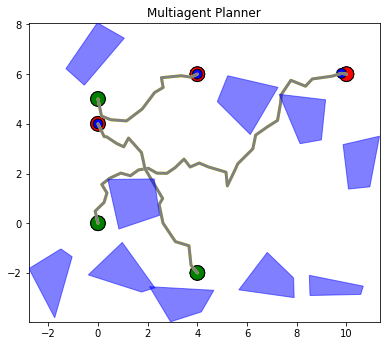

Runtime completed. Time:  45


In [10]:
agents = [Agent("normal", received_bid, received_waypoints, [0, 0], [10, 6], env, 0.5, 200),
          Agent("normal", received_bid, received_waypoints, [0, 5], [4, 6], env, 0.5, 200),
          Agent("normal", received_bid, received_waypoints, [4, -2], [0, 4], env, 0.5, 200)]

plan = Plan(agents, env, dma_individual, 100)

plan.spin(75)

You can check your implementation here.

## Conceptual Question 4 - Cooperative DMA-RRT (5 pts) <a id="concept4"/>

Cooperative DMA-RRT layers a protocol for asking other agents to alter their plans on top of DMA-RRT's bidding process. Using the notion of broadcasting "emergency stops" alongside waypoints, Cooperative DMA-RRT claims to improve the global optimality of the system. See the tutorial for more information.

Let's think about risk at a high level. How does the global optimality of a system of distributed agents impact the risk associated with path planning? Would you expect that agents would take on more risk in a more optimized system? Less risk? Why or why not?

YOUR ANSWER HERE

---

A more optimized plan is one where agents are taking more direct routes to goals. Take the idea of an street intersection as an example. In a fully optimized system, agents would slightly alter their speed to adjust their timing on approach to the intersection to narrowly avoid cross traffic. Humans are unable to do this, so instead we use a less optimized system of taking turns. This increases the distance between vehicles. In a similar way, agents in a more optimized system would be willing to create paths that approach closer to one another, hence increasing risk.

## Performance Analysis <a id="analysis"/>

RRT* and DMA-RRT have many parameters for performance tuning. Let's take a look at one of the more impactful - $\Delta t$, or the amount of time permitted during RRT to grow trees. $\Delta t$ corresponds to `rrt_iters`, or the number of iterations of RRT tree-growth to run during planning, in the `Agent` constructor API. In the next cells, use your implementation of DMA-RRT to experiment with the impact of modifying `rrt_iters`.

In [ ]:
rrt_iters = 200

agents = [Agent("normal", received_bid, received_waypoints, [0, 0], [10, 6], env, 0.4, rrt_iters),
          Agent("normal", received_bid, received_waypoints, [0, 5], [4, 6], env, 0.4, rrt_iters),
          Agent("normal", received_bid, received_waypoints, [4, -2], [0, 4], env, 0.4, rrt_iters)]

plan = Plan(agents, env, dma_individual, 100)
plan.spin(75)

In [ ]:
rrt_iters = 300

agents = [Agent("normal", received_bid, received_waypoints, [0, 0], [10, 6], env, 0.4, rrt_iters),
          Agent("normal", received_bid, received_waypoints, [0, 5], [4, 6], env, 0.4, rrt_iters),
          Agent("normal", received_bid, received_waypoints, [4, -2], [0, 4], env, 0.4, rrt_iters)]

plan = Plan(agents, env, dma_individual, 100)
plan.spin(75)

In [ ]:
rrt_iters = 400

agents = [Agent("normal", received_bid, received_waypoints, [0, 0], [10, 6], env, 0.4, rrt_iters),
          Agent("normal", received_bid, received_waypoints, [0, 5], [4, 6], env, 0.4, rrt_iters),
          Agent("normal", received_bid, received_waypoints, [4, -2], [0, 4], env, 0.4, rrt_iters)]

plan = Plan(agents, env, dma_individual, 100)
plan.spin(75)

### Conceptual Question 5 - The Impact of $\Delta t$ (5 pts) <a id="concept5"/>

How does $\Delta t$ impact the performance of DMA-RRT? If you were implementing a real-world version of DMA-RRT, what metrics would you use to tune the planning time of your agents?

YOUR ANSWER HERE

---

As $\Delta t$ grows, DMA-RRT slows down. Agents are allowed more time to plan. With RRT\* that means the paths are potentially more optimized, but it comes at the cost of taking longer for each turn to complete.

In the real world, I would compare the time it takes to replan to the total execution time. I would increase the planning time until such a point that it was non-negligible in comparison to the execution time. I would expect that planning should be done while executing, and as such so long as there is little chance of planning taking longer than executing, I would be comfortable increasing the planning time.

### Conceptual Question 6 - Limitations of DMA-RRT (5 pts) <a id="concept6"/>

How would DMA-RRT scale with the number of agents? We only simulated environments with a few agents in this problem set, but could it feasibly be run with 100s or 1000s of independent agents? Why or why not?

YOUR ANSWER HERE

---

The two factors that will determine the scalability of DMA-RRT is the time it takes to model peer paths and the time to bid.

Any lag or communication issues in the network of agents will dramatically impact the time to bid. Our implementation modeled a fully-connected, lag-free network of agents. So long as all agents can communicate, bidding should be a quick process regardless of the number of agents. However, any real world system would need to address communication delays and dropouts. If not, a single agent with communication issues would inhibit the bidding process, slowing down planning across all agents.

Assuming it remains computationally cheap to model the paths of other agents, then it seems likely that DMA-RRT could scale to high numbers of agents. 

## **You're Done!**
Don't forget to validate your notebook and submit.